In [1]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Cityscapes(root='data/cityscapes', split='train', mode='fine',
                      target_type='semantic')

In [3]:
dataset[0][0].size

(2048, 1024)

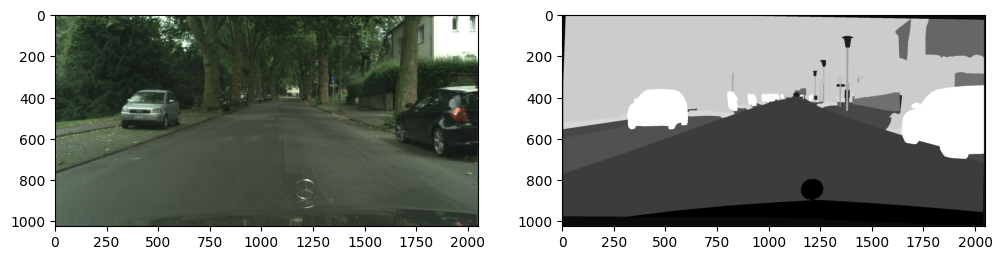

In [4]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

### Utility functions

In [5]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [6]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [7]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [8]:
import torchvision.transforms as transforms

mean = torch.tensor([0.4865, 0.4998, 0.4323])
std = torch.tensor([0.2326, 0.2276, 0.2659])
image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size, transforms.InterpolationMode.BILINEAR),  # Resize the smallest side to 128 and maintain aspect ratio
    transforms.CenterCrop(image_size), 
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # [0, 1] -> [-1, 1]
    transforms.Normalize(mean=mean, std=std), 
])

transform_mask = transforms.Compose([
    transforms.Resize(image_size, transforms.InterpolationMode.NEAREST),  # Use NEAREST for masks to avoid interpolation of label classes
    transforms.CenterCrop(image_size),
    #transforms.ToTensor(),
])

def denorm(image):

    # Denormalize
    x_adj = (image * std + mean) * 255
    x_adj = x_adj.clamp(0, 255).type(torch.uint8)
    return x_adj

In [9]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes
import torch

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if image is None:
            print(self.images[index])
            dummy_image = torch.randn(3, 256, 256) 
            target = self.target_transform(target) if isinstance(target, Image.Image) else target
            target = torch.tensor(np.array(target))
            return dummy_image, target
            

        if self.transforms is not None:
            image = self.transform(image)
            target = self.target_transform(target) if isinstance(target, Image.Image) else target
            target = torch.tensor(np.array(target))
                
        return image, target
    

In [10]:
dataset=MyClass('data/cityscapes', split='val', mode='fine',
                     target_type='semantic',transform=transform, target_transform=transform_mask)
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 128, 128]) torch.Size([128, 128])


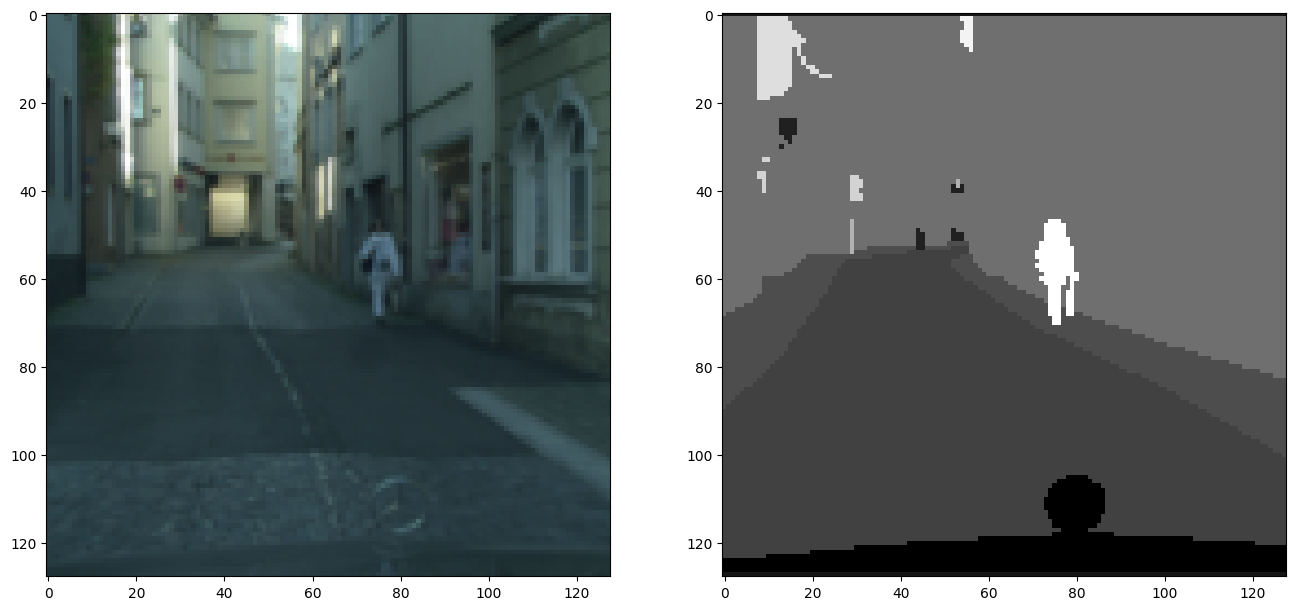

In [11]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(denorm(img.permute(1, 2, 0)))
ax[1].imshow(seg,cmap='gray')

In [12]:

#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  7,  8, 11, 17, 20, 21, 23, 24], dtype=torch.uint8)
11


In [13]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([128, 128])
tensor([ 0,  1,  2,  3,  6,  8,  9, 11, 12], dtype=torch.uint8)
9


In [14]:
res1=decode_segmap(res.clone())

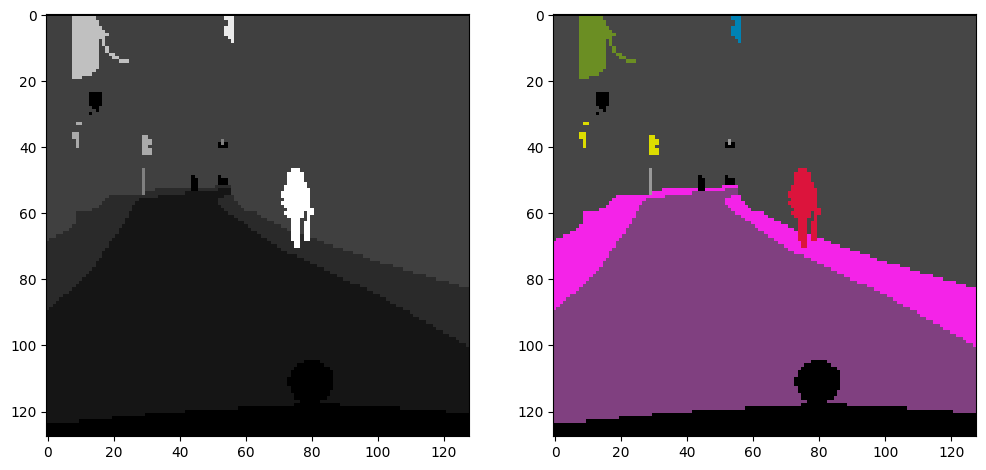

In [15]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

### Train

In [16]:
from torchvision import models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset
train_dataset = MyClass('data/cityscapes', split='train', mode='fine',
                           target_type='semantic', transform=transform, target_transform=transform_mask)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset = MyClass('data/cityscapes', split='val', mode='fine',
                         target_type='semantic', transform=transform, target_transform=transform_mask)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



In [17]:
torch.cuda.is_available()

True

In [18]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp

from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch

class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=n_classes,                      # model output channels (number of classes in your dataset)
            )
  
  #parameters
    self.lr=1e-3
    self.batch_size=128
    self.numworker=multiprocessing.cpu_count()//4

    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(num_classes=n_classes, task='multiclass')
    
    self.train_class = MyClass('data/cityscapes', split='train', mode='fine',
                     target_type='semantic',transform=transform, target_transform=transform_mask)
    self.val_class = MyClass('data/cityscapes', split='val', mode='fine',
                     target_type='semantic',transform=transform, target_transform=transform_mask)
    
    
  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    iou=self.metrics(out,segment)
    return loss,iou
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('train_loss', loss,on_step=True, on_epoch=True,prog_bar=True)
    self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,num_workers=self.numworker,pin_memory=True)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [19]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)

In [20]:
trainer = Trainer(max_epochs=200,
                  devices=-1,
                  precision=16,
                  callbacks=[checkpoint_callback],
                 )

/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/lightning_fabric/connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard su

In [21]:
trainer.fit(model)
torch.save(model.state_dict(), 'model-resnet101.pth')

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | layer     | Unet                   | 51.5 M
1 | criterion | DiceLoss               | 0     
2 | metrics   | MulticlassJaccardIndex | 0     
-----------------------------------------------------
51.5 M    

/home/talmacsi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 199: 100%|██████████| 24/24 [00:58<00:00,  2.44s/it, v_num=4, train_loss_step=0.273, train_loss_epoch=0.160]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 24/24 [01:00<00:00,  2.50s/it, v_num=4, train_loss_step=0.273, train_loss_epoch=0.160]


In [22]:
test_class = MyClass('data/cityscapes', split='val', mode='fine',
                     target_type='semantic',transform=transform, target_transform=transform_mask)
test_loader=DataLoader(test_class, batch_size=12, 
                      shuffle=False)

In [23]:
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break
print(img.shape,seg.shape,output.shape) 

torch.Size([12, 3, 128, 128]) torch.Size([12, 128, 128]) torch.Size([12, 20, 128, 128])


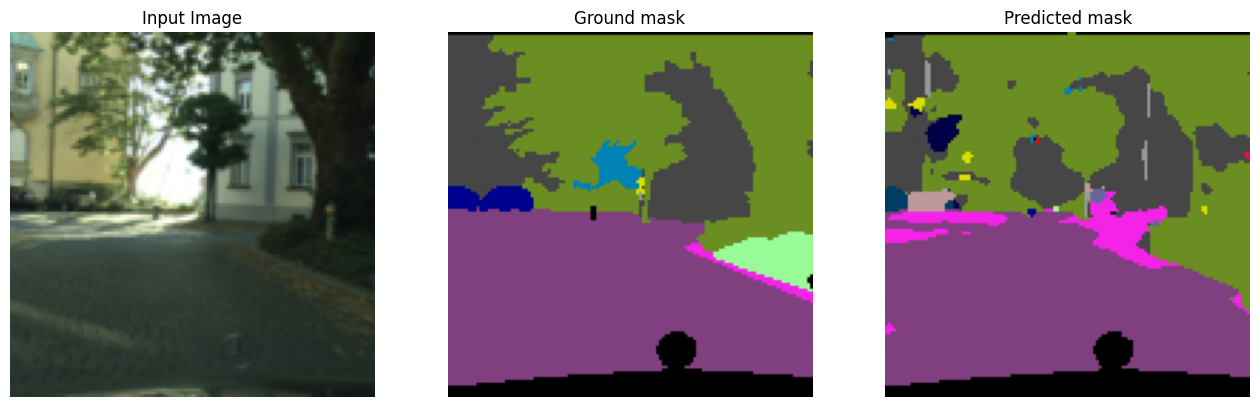

In [25]:
sample=1
invimg=denorm(img[sample].permute(1,2,0))
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(invimg.numpy()) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')